In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import BinaryIoU


In [2]:
# Define data paths
images_dir = os.path.join("Dataset")


In [3]:
# Function to load and preprocess data
def load_data(images_dir, img_size=(256, 256)):
    images = []
    masks = []
    for i in range(1,21):
        img_path = os.path.join(images_dir, "Image{:02d}.jpg".format(i))
        mask_path = os.path.join(images_dir, "Image{:02d}_label.jpg".format(i))
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=img_size)
        mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

In [4]:
# Load and preprocess data
images, masks = load_data(images_dir)

In [5]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [6]:
# Define the model architecture (U-Net)
def unet_model(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
# Build the model
model = unet_model(input_shape=(256, 256, 3))

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',BinaryIoU()])

In [95]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0119 - accuracy: 0.9917 - binary_io_u_1: 0.9043 - val_loss: 0.0194 - val_accuracy: 0.9907 - val_binary_io_u_1: 0.8396
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.0119 - accuracy: 0.9917 - binary_io_u_1: 0.9052 - val_loss: 0.0202 - val_accuracy: 0.9904 - val_binary_io_u_1: 0.8351
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.0118 - accuracy: 0.9917 - binary_io_u_1: 0.9049 - val_loss: 0.0206 - val_accuracy: 0.9903 - val_binary_io_u_1: 0.8328
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.0118 - accuracy: 0.9917 - binary_io_u_1: 0.9048 - val_loss: 0.0201 - val_accuracy: 0.9904 - val_binary_io_u_1: 0.8360
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.0117 - accuracy: 0.9917 - binary_io_u_1: 0.9057 - val_loss: 0.0201 - val_accuracy: 0.9904 - val_binary_io_u_1: 0.8356
Epoch 6/10
1/1 [==============================] - 5s 5s

In [11]:
# Evaluate the model
loss, iou_score, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy:{accuracy}, Mean IOU: {iou_score}')

1/1 [==============================] - 0s 310ms/step - loss: 0.0175 - accuracy: 0.9919 - binary_io_u: 0.8664
Validation Loss: 0.017513293772935867, Validation Accuracy:0.8664020895957947, Mean IOU: 0.9919281005859375


In [23]:
# Make predictions
predicted_masks = model.predict(images)

1/1 [==============================] - 3s 3s/step


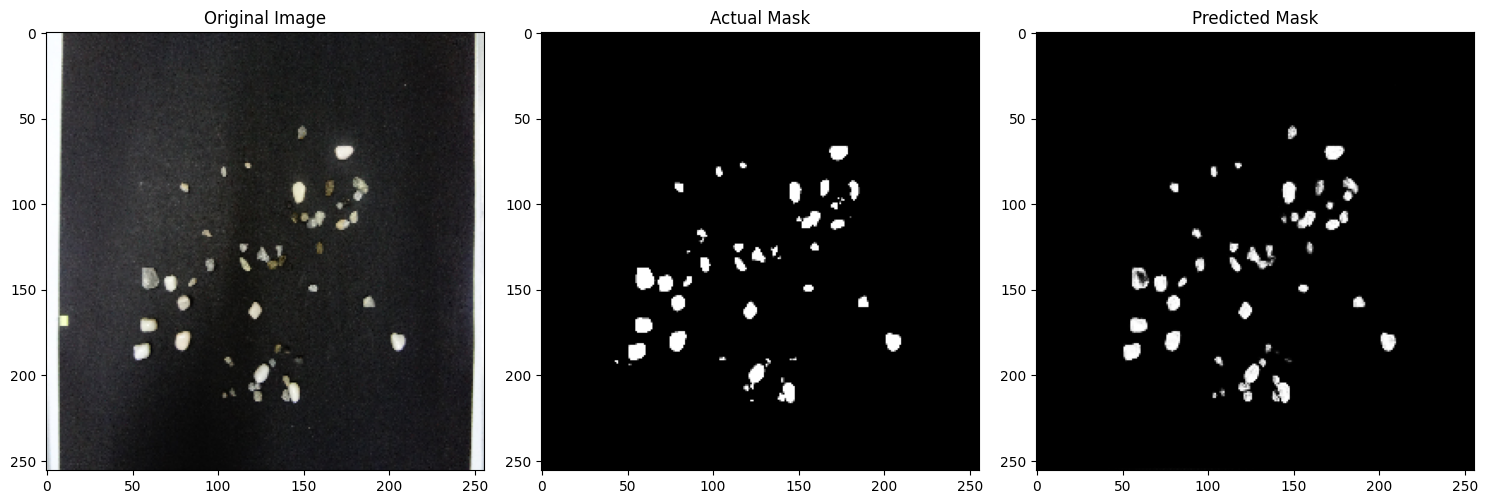

In [120]:
list1 = []
for i in range(0,20):
    list1.append(i)
# Plot predictions
num_plots = 20
sample = np.array(list1)

plt.figure(figsize=(15, 6*num_plots))
for i, idx in enumerate(sample):
    plt.subplot(num_plots, 3, 3*i + 1)
    plt.imshow(images[idx].astype('uint8'))
    plt.title('Original Image')
    
    plt.subplot(num_plots, 3, 3*i + 2)
    plt.imshow(masks[idx].squeeze(), cmap='gray')
    plt.title('Actual Mask')
    
    plt.subplot(num_plots, 3, 3*i + 3)
    plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
    plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


In [83]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [110]:
model.save("predict.keras")

In [9]:
model.load_weights('predict.keras')

In [42]:
img = tf.keras.preprocessing.image.load_img("Dataset/Image01.jpg", target_size=(256,256))
img = tf.keras.preprocessing.image.img_to_array(img)
mask = tf.keras.preprocessing.image.load_img("Dataset/Image01_label.jpg",color_mode="grayscale" ,target_size=(256,256))
mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0

In [43]:
l1 = []
l1.append(img)
l1 = np.array(l1)
l2 = []
l2.append(mask)
l2 = np.array(l2)


In [44]:
prediction = model.predict(l1)

1/1 [==============================] - 0s 180ms/step


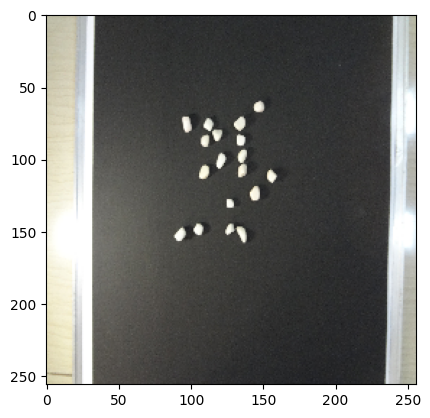

In [53]:
plt.imshow(l1[0].astype('uint8')) # Original Image


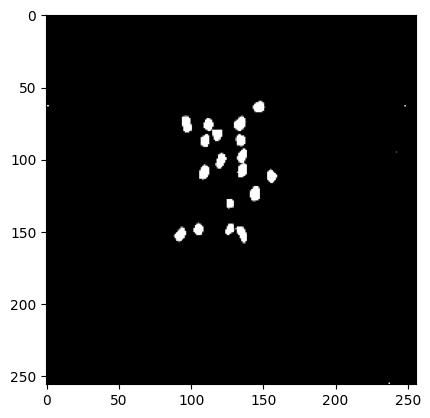

In [51]:
plt.imshow(l2[0],cmap="gray") # Actual Mask


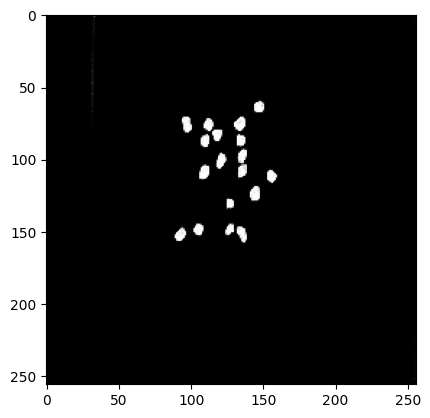

In [48]:


plt.imshow(prediction[0],cmap="gray") #Predicted Mask